### This is where the simulation is modified to allow for multiple sessions, for monitoring performance of traders, specificially the Market Maker strategy 

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

What is the right amount of simulations to run? The below demonstrates how this is discovered for the simulation 

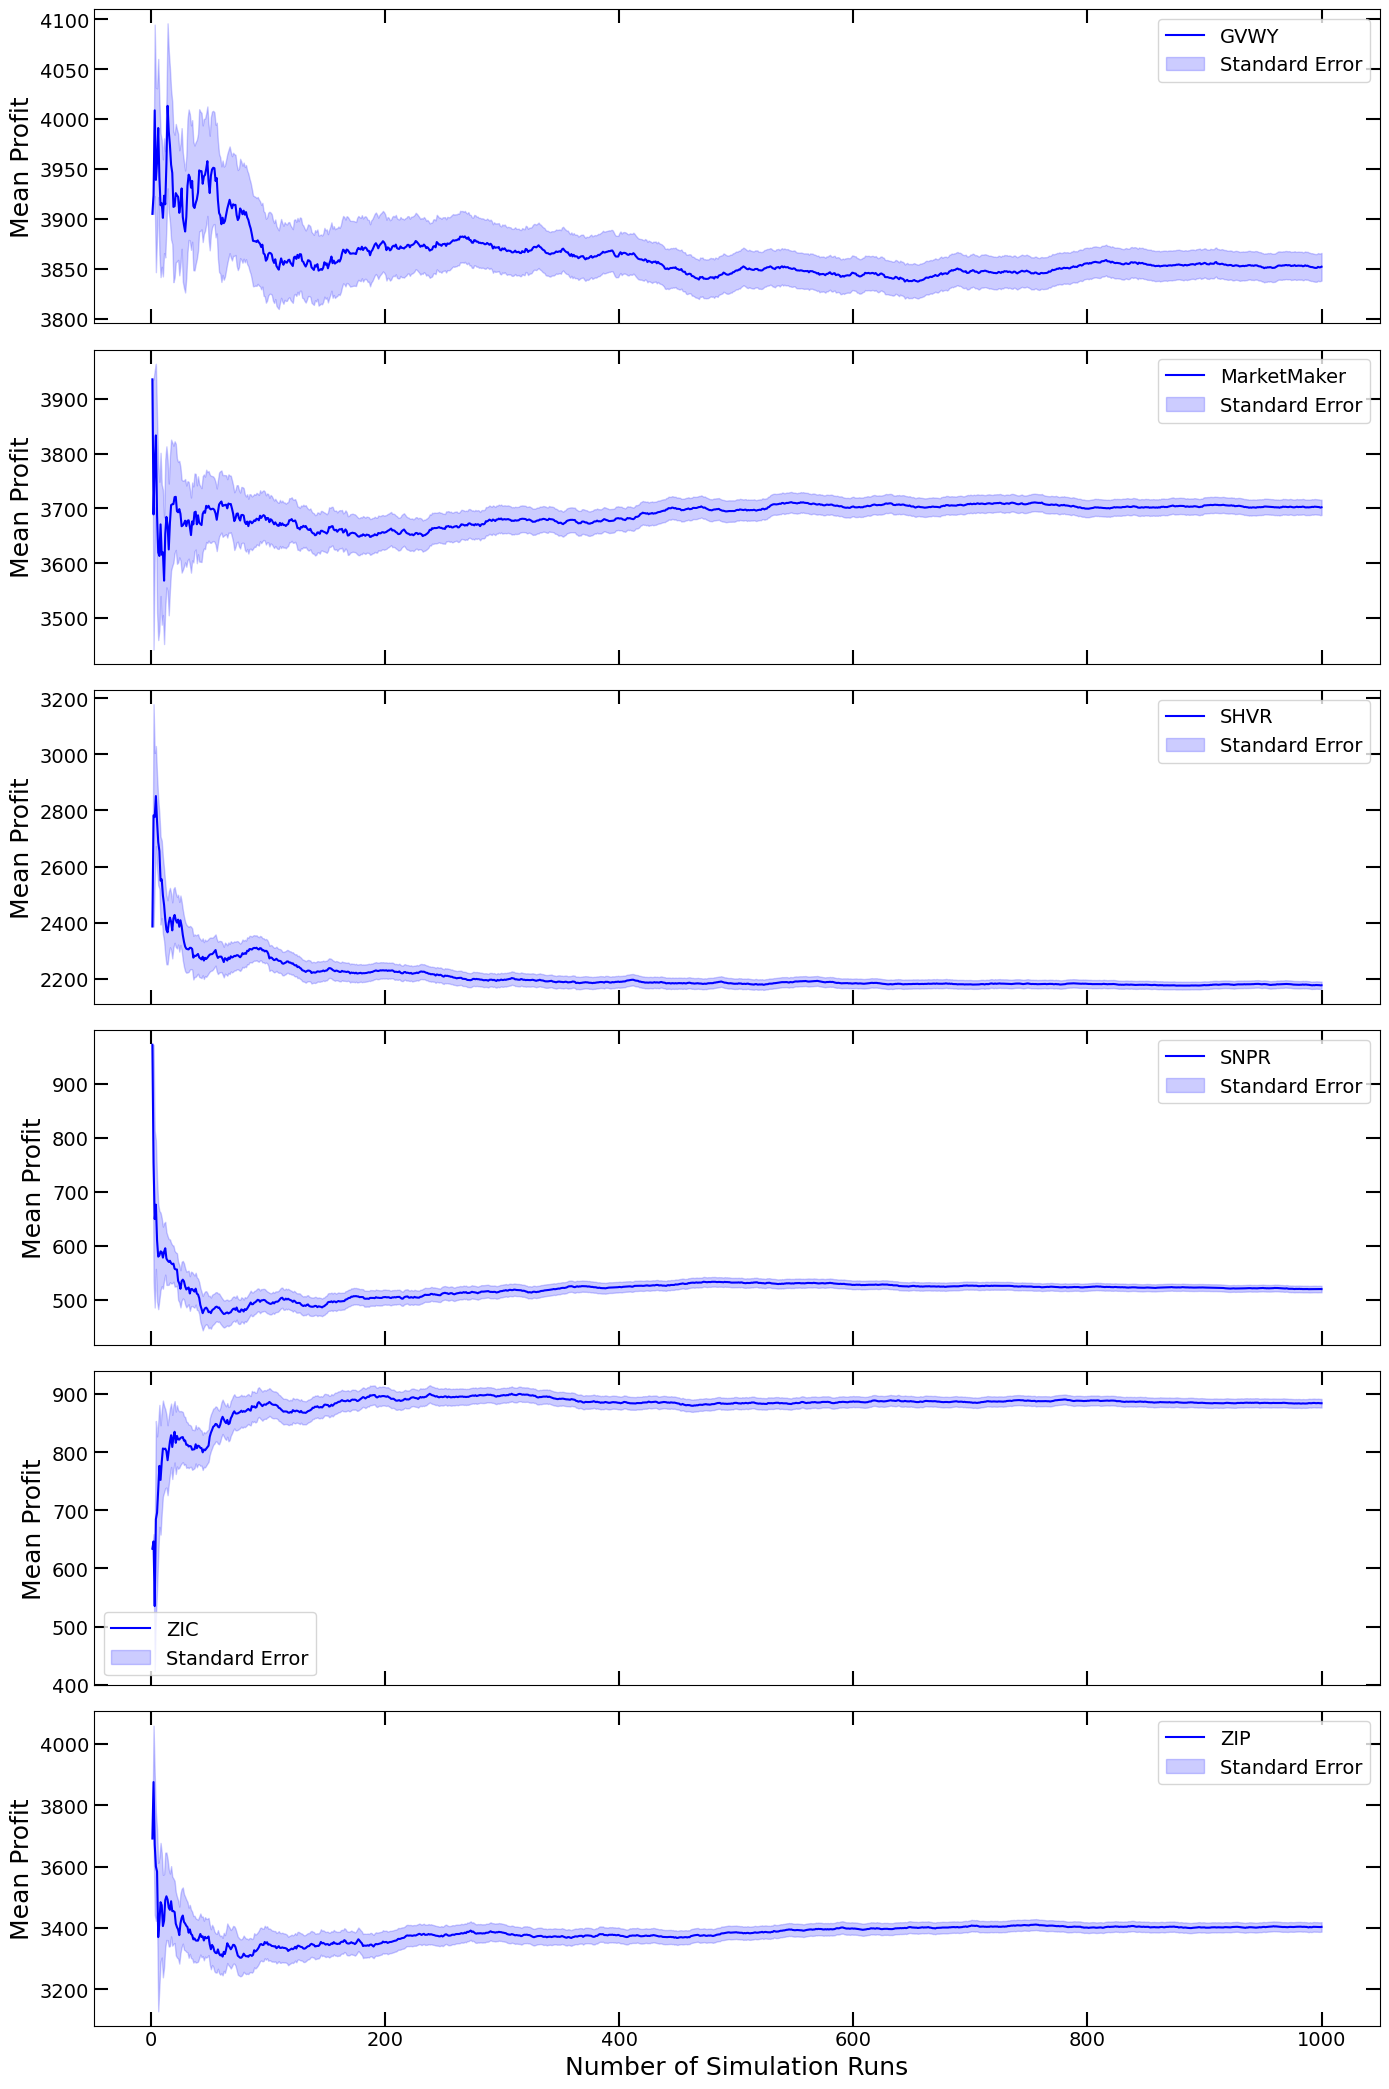

In [2]:

# Read in your CSV file.
df = pd.read_csv('bigtestdata10.csv')

# Group by Trial and TraderType and pick the row with the maximum 'Time' for each group,
# then extract the 'TotalProfit' from that row.
final_profits = df.groupby(['Trial', 'TraderType']).apply(lambda g: g.loc[g['Time'].idxmax(), 'TotalProfit'])

# Reshape the Series into a DataFrame where rows are trials and columns are trader types.
final_profits = final_profits.unstack(level='TraderType').sort_index()

# Get the trader types (columns)
trader_types = final_profits.columns

# Create subplots: one subplot per trader type arranged vertically.
num_trader_types = len(trader_types)
fig, axs = plt.subplots(num_trader_types, 1, figsize=(14, 3.5*num_trader_types), sharex=True)

# If there's only one trader type, wrap the axis in a list.
if num_trader_types == 1:
    axs = [axs]

# For each trader type, compute the running (cumulative) mean profit and standard error,
# then plot these with a shaded region for the standard error.
for ax, ttype in zip(axs, trader_types):
    data = final_profits[ttype]
    n = len(data)
    
    # Compute cumulative (running) mean and standard error using the expanding() method.
    cum_mean = data.expanding(min_periods=1).mean()
    cum_std = data.expanding(min_periods=2).std(ddof=1)
    indices = np.arange(1, n+1)
    cum_se = cum_std / np.sqrt(indices)
    cum_se.iloc[0] = 0  # No error for the first data point

    # Plot running mean and shaded standard error region.
    ax.plot(indices, cum_mean, label=ttype, color='blue')
    ax.fill_between(indices, cum_mean - cum_se, cum_mean + cum_se, color='blue', alpha=0.2, label='Standard Error')
    ax.set_ylabel('Mean Profit', fontsize=18)
    
    # Set tick parameters for this subplot.
    ax.tick_params(axis='both', which='major', direction='in', length=10, width=1.5,
                   labelsize=14, top=True, bottom=True, left=True, right=True)
    ax.legend(fontsize=14)

# Set common x-axis label for the bottom subplot.
axs[-1].set_xlabel('Number of Simulation Runs', fontsize=18)

plt.tight_layout()
plt.show()


In [31]:
import os
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange, market_session, populate_market, customer_orders

# Define time parameters
end_time = 60 * 2  # 2 minutes simulation time

quantity = 1
# Define trader specifications

traders_spec = {
    'buyers': [('ZIC', quantity),  ('SHVR', quantity), ('ZIP', quantity), ('GVWY', quantity), ('SNPR', quantity)],
    'sellers': [('ZIC', quantity),  ('SHVR', quantity), ('ZIP', quantity), ('GVWY', quantity), ('SNPR', quantity)],
}

# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-poisson',
    'interval': 0.1,
}

# === Trader Class (Tracks Initial Balance for Profit Calculation) ===
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        if verbose:
            print(f"{self.tid}: Profit={profit}, Balance={self.balance}")

# === Function to Run a Single Market Session ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs data."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob)

        time += timestep

# === Function to Log Trader Statistics in CSV ===
def write_trade_stats(expid, traders, tdump, time, lob):
    trader_types = {}

    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance - trader.initial_balance  # Corrected profit calculation

        # Track statistics for each trader type
        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['profit_sum'] += profit 
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {'balance_sum': balance, 'profit_sum': profit, 'n': 1}

    # Write results to CSV
    for ttype, stats in trader_types.items():
        avg_profit = stats['profit_sum'] / stats['n']
        profit_type = "Positive" if stats['profit_sum'] >= 0 else "Negative"

        tdump.write(
            f"{expid},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['profit_sum']},{profit_type}\n"
        )

# === Run Multiple Market Sessions and Save to CSV ===
output_file = 'bigtestdata10.csv'
with open(output_file, 'w') as tdump:
    tdump.write("Trial,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")

    max_trials = 1000
    for trial in range(1, max_trials + 1):
        tid = f'trial{trial:04d}'
        print(f"Running trial {trial}/{max_trials}...")

        market_session_with_logging(
            tid, 0.0, end_time, traders_spec, order_schedule,
            {
                'dump_tape': False, 'dump_strats': False,
                'dump_lobs': False, 'dump_blotters': False,
                'dump_avgbals': False,
            },
            verbose=False, tdump=tdump
        )

print(f"Completed {max_trials} trials. Results saved to {output_file}.")


Running trial 1/1000...
Running trial 2/1000...
Running trial 3/1000...
Running trial 4/1000...
Running trial 5/1000...
Running trial 6/1000...
Running trial 7/1000...
Running trial 8/1000...
Running trial 9/1000...
Running trial 10/1000...
Running trial 11/1000...
Running trial 12/1000...
Running trial 13/1000...
Running trial 14/1000...
Running trial 15/1000...
Running trial 16/1000...
Running trial 17/1000...
Running trial 18/1000...
Running trial 19/1000...
Running trial 20/1000...
Running trial 21/1000...
Running trial 22/1000...
Running trial 23/1000...
Running trial 24/1000...
Running trial 25/1000...
Running trial 26/1000...
Running trial 27/1000...
Running trial 28/1000...
Running trial 29/1000...
Running trial 30/1000...
Running trial 31/1000...
Running trial 32/1000...
Running trial 33/1000...
Running trial 34/1000...
Running trial 35/1000...
Running trial 36/1000...
Running trial 37/1000...
Running trial 38/1000...
Running trial 39/1000...
Running trial 40/1000...
Running t

In [90]:
'''

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('bigtestdata.csv')

# Get unique trader types
trader_types = df['TraderType'].unique()
num_traders = len(trader_types)

# Create a single-row, multi-column subplot layout
fig, axes = plt.subplots(nrows=1, ncols=num_traders, figsize=(4 * num_traders, 8), sharey=True)

# If there's only one trader type, `axes` is not a list, so we wrap it
if num_traders == 1:
    axes = [axes]

# Iterate over each TraderType and plot on separate subplots
for ax, trader_type in zip(axes, trader_types):
    trader_data = df[df['TraderType'] == trader_type]
    for trial in trader_data['Trial'].unique():
        trial_data = trader_data[trader_data['Trial'] == trial]
        ax.plot(trial_data['Time'], trial_data['TotalProfit'] / quantity , label=f'Trial {trial}')
    
    # Add horizontal line at y = 0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    ax.set_xlabel('Time')
    ax.set_title(f'{trader_type}')

# Add common Y-axis label
fig.supylabel('Profit')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
'''

"\n\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the data\ndf = pd.read_csv('bigtestdata.csv')\n\n# Get unique trader types\ntrader_types = df['TraderType'].unique()\nnum_traders = len(trader_types)\n\n# Create a single-row, multi-column subplot layout\nfig, axes = plt.subplots(nrows=1, ncols=num_traders, figsize=(4 * num_traders, 8), sharey=True)\n\n# If there's only one trader type, `axes` is not a list, so we wrap it\nif num_traders == 1:\n    axes = [axes]\n\n# Iterate over each TraderType and plot on separate subplots\nfor ax, trader_type in zip(axes, trader_types):\n    trader_data = df[df['TraderType'] == trader_type]\n    for trial in trader_data['Trial'].unique():\n        trial_data = trader_data[trader_data['Trial'] == trial]\n        ax.plot(trial_data['Time'], trial_data['TotalProfit'] / quantity , label=f'Trial {trial}')\n    \n    # Add horizontal line at y = 0\n    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)\n    \n    ax.set_xlabel('T

In [91]:
df = pd.read_csv('bigtestdata10.csv')
df['TotalProfit'] = df['TotalProfit'] / quantity

In [92]:
# Filter the dataframe to get the final time point
final_time = df['Time'].max()
final_data = df[df['Time'] == final_time]

# Group by TraderType and calculate the mean, standard deviation, and variance of TotalProfit
profit_stats = final_data.groupby('TraderType')['TotalProfit'].agg(['mean', 'std', 'var'])

profit_stats

,mean,std,var
TraderType,,,
GVWY,1603.101,298.969868,89382.981781
MarketMaker,1553.946,309.897266,96036.315399
SHVR,768.048,242.267718,58693.647343
SNPR,198.317,117.813431,13880.004516
ZIC,414.892,159.163581,25333.045381
ZIP,1520.346,325.874212,106194.002286


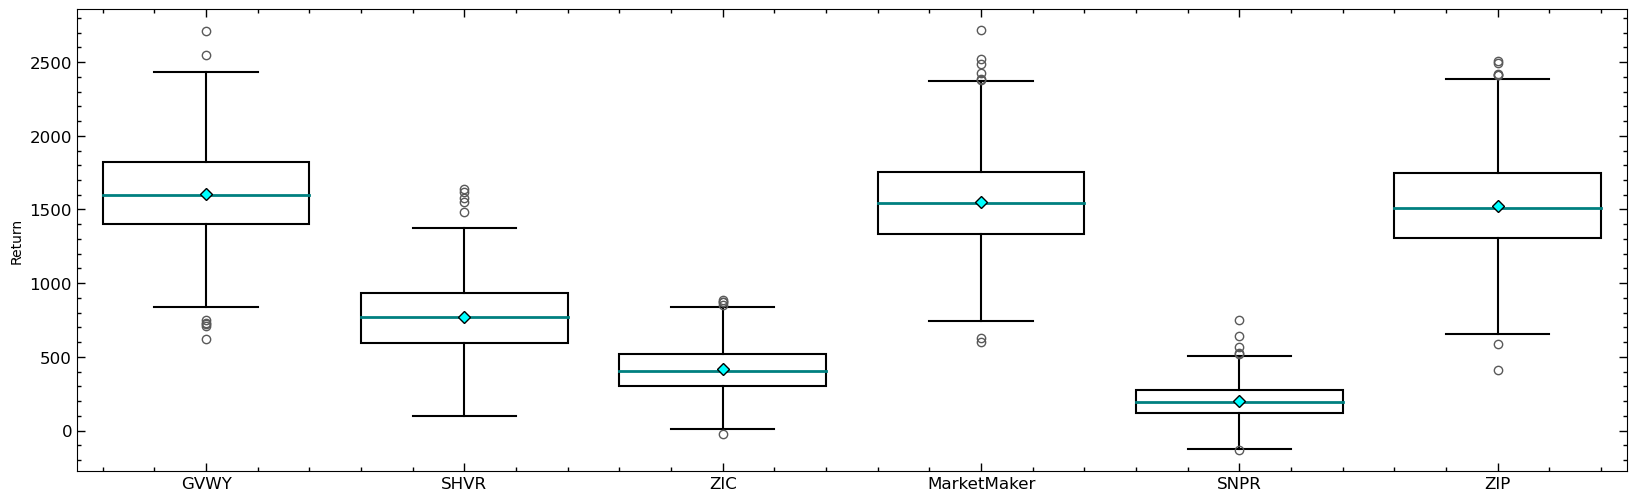

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: final_data is your DataFrame with columns ['TraderType', 'TotalProfit']
# and you've already filtered to the final time, etc.

plt.figure(figsize=(20, 6))

sns.boxplot(
    x='TraderType', 
    y='TotalProfit', 
    data=final_data,
    showmeans=True,
    palette="Set2",
    # Make the boxes clear (transparent)
    boxprops={
        "facecolor": "none",     # no fill
        "edgecolor": "black",    # box outline color
        "linewidth": 1.5
    },
    # Optionally adjust whiskers, medians, outliers, etc.
    whiskerprops={"color":"black","linewidth":1.5},
    capprops={"color":"black","linewidth":1.5},
    medianprops={"color":"teal","linewidth":2},
    flierprops={
        "marker":"o",
        "markerfacecolor":"none",
        "markersize":6,
        "linestyle":"none"
    },
    meanprops={
        "marker":"D",
        "markerfacecolor":"cyan",
        "markeredgecolor":"black",
        "markersize":6
    }
)


plt.minorticks_on() # Enable minor ticks for the first subplot
plt.tick_params(axis='both', which='major', direction='in', length=6, width=1, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    top=True, bottom=True, left=True, right=True)
    

    # Apply thicker border edges to both subplots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)

plt.xlabel('')
plt.ylabel('Return')
plt.show()

In [49]:
df = pd.read_csv('bigtestdata.csv')
marketmaker_data = df[df['TraderType'] == 'MarketMaker']
profit_change = marketmaker_data['TotalProfit'].diff()


In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data (adjust as needed)
# marketmaker_data['ProfitChange'] = marketmaker_data['TotalProfit'].diff()
df = pd.read_csv('bigtestdata.csv')
marketmaker_data = df[df['TraderType'] == 'MarketMaker']
zip_data = df[df['TraderType'] == 'ZIP']
zic_data = df[df['TraderType'] == 'ZIC']
profit_change = marketmaker_data['TotalProfit'].diff()
marketmaker_data['ProfitChange'] = profit_change

Big test data

In [22]:
df = pd.read_csv('bigtestdata10.csv')
df

,Trial,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType
0,trial0001,0.0,None,None,SHVR,0.0,0.0,Positive
1,trial0001,0.0,None,None,ZIP,0.0,0.0,Positive
2,trial0001,0.0,None,None,MarketMaker,0.0,0.0,Positive
3,trial0001,0.0,None,None,ZIC,0.0,0.0,Positive
4,trial0001,0.0,None,None,SNPR,0.0,0.0,Positive
...,...,...,...,...,...,...,...,...
172915,trial0020,120.0,67,86,GVWY,1519.0,1519.0,Positive
172916,trial0020,120.0,67,86,SHVR,838.0,838.0,Positive
172917,trial0020,120.0,67,86,ZIP,1244.0,1244.0,Positive
172918,trial0020,120.0,67,86,MarketMaker,1873.0,1873.0,Positive
